In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import pickle

In [2]:
def read_excel(path):
    return pd.read_excel(path)

In [3]:
path_1 = '../Data/Preprocessing/Data Losarang/2023/1_input_losarang_2023.xlsx'
path_2 = '../Data/Preprocessing/Data Losarang/2023/1_missing_times_losarang_2023.xlsx'

data_terisi = read_excel(path_1)
data_kosong = read_excel(path_2)

In [4]:
data_terisi.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2023-01-01 00:00:00,2023,1,1,1,Sunday,00:00,85,24,4,113,68.0,24,10.0,102
1,2023-01-01 00:15:00,2023,1,1,1,Sunday,00:15,92,19,6,117,73.6,19,15.0,108
2,2023-01-01 00:30:00,2023,1,1,1,Sunday,00:30,78,16,6,100,62.4,16,15.0,93
3,2023-01-01 00:45:00,2023,1,1,1,Sunday,00:45,78,23,4,105,62.4,23,10.0,95
4,2023-01-01 01:00:00,2023,1,1,1,Sunday,01:00,76,14,6,96,60.8,14,15.0,90


In [5]:
# Menghitung IQR dan menghilangkan outlier untuk setiap kombinasi hari dan jam
def remove_outliers(df, column):
    # Mengelompokkan data berdasarkan 'HARI' dan 'JAM'
    grouped = df.groupby(['HARI', 'JAM'])

    # Fungsi untuk menghitung batas dan memfilter outlier
    def filter_outliers(sub_df):
        Q1 = sub_df[column].quantile(0.25)
        Q3 = sub_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return sub_df[(sub_df[column] >= lower_bound) & (sub_df[column] <= upper_bound)]
    
    # Menerapkan filter outlier ke setiap grup
    return grouped.apply(filter_outliers).reset_index(drop=True)

In [6]:
a = len(data_terisi)
# Kolom untuk dibersihkan dari outlier, misal 'MOTOR'
data_terisi = remove_outliers(data_terisi, 'SMP')
b = len(data_terisi)

In [7]:
print(a, b, a-b)

20909 19067 1842


In [8]:
data_kosong.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2023-01-20 00:15:00,2023,1,3,20,Friday,00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-20 00:30:00,2023,1,3,20,Friday,00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-20 00:45:00,2023,1,3,20,Friday,00:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-20 01:00:00,2023,1,3,20,Friday,01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-20 01:15:00,2023,1,3,20,Friday,01:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Menggabungkan data
data = data_terisi.copy()

In [10]:
# Preprocessing
encoder = OneHotEncoder(sparse_output=False)
scaled_features = StandardScaler()

In [11]:
# Misal meng-encode fitur 'HARI'
encoded_days = encoder.fit_transform(data_terisi[['HARI']])

In [12]:
# Konversi 'JAM' ke total menit sejak tengah malam
data['JAM'] = data_terisi['JAM'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [13]:
# Skala fitur 'JAM', 'MOBIL', 'TRUK/BUS'
scaled_features = scaled_features.fit_transform(data[['JAM', 'MOTOR', 'TRUK/BUS']])

In [14]:
data.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2023-01-06,2023,1,1,6,Friday,0,28,45,43,116,22.4,45,107.5,175
1,2023-01-13,2023,1,2,13,Friday,0,29,47,35,111,23.2,47,87.5,158
2,2023-01-20,2023,1,3,20,Friday,0,23,44,39,106,18.4,44,97.5,160
3,2023-03-31,2023,3,5,31,Friday,0,21,30,65,116,16.8,30,162.5,209
4,2023-04-07,2023,4,1,7,Friday,0,94,72,90,256,75.2,72,225.0,372


In [15]:
# Gabungkan kembali ke DataFrame
encoded_days = pd.DataFrame(encoded_days, columns=encoder.get_feature_names_out(['HARI']))
scaled_features = pd.DataFrame(scaled_features, columns=['JAM', 'MOTOR', 'TRUK/BUS'])
data_preprocessed = pd.concat([data.drop(['HARI', 'JAM', 'MOTOR', 'TRUK/BUS'], axis=1), encoded_days, scaled_features], axis=1)

In [16]:
data_preprocessed.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,MOBIL,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,...,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM,MOTOR,TRUK/BUS
0,2023-01-06,2023,1,1,6,45,116,22.4,45,107.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.729224,-1.398517,-1.175302
1,2023-01-13,2023,1,2,13,47,111,23.2,47,87.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.729224,-1.386331,-1.427446
2,2023-01-20,2023,1,3,20,44,106,18.4,44,97.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.729224,-1.459447,-1.301374
3,2023-03-31,2023,3,5,31,30,116,16.8,30,162.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.729224,-1.483818,-0.481907
4,2023-04-07,2023,4,1,7,72,256,75.2,72,225.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.729224,-0.594245,0.306042


# Prediksi Mobil

In [17]:
# Bagi data menjadi fitur dan target
X = data_preprocessed.drop(['TAHUN','WAKTU','TANGGAL','JUMLAH','SMP_MTR','SMP_MBL','SMP_TRK', 'SMP','MOTOR','MOBIL','TRUK/BUS','BULAN','PEKAN'], axis=1)
y = data_preprocessed['MOBIL']

In [18]:
# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train

,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM
16177,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.167582
1714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.588221
8797,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.294703
18452,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.841691
15323,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.117490
...,...,...,...,...,...,...,...,...
11284,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.710733
11964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.823972
5390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.529683
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.534292


In [20]:
y_train

16177     70
1714      74
8797      61
18452     80
15323     61
        ... 
11284     72
11964     55
5390      38
860       92
15795    107
Name: MOBIL, Length: 15253, dtype: int64

In [21]:
mses = {}
maes = {}
rmses = {}
r2s  = {}

# Rata-rata hari dan jam

In [22]:
data_terisi_train = data_terisi.loc[X_train.index]
data_terisi_test = data_terisi.loc[X_test.index]
len(data_terisi_train), len(data_terisi_test), len(data_terisi_train) + len(data_terisi_test)

(15253, 3814, 19067)

In [23]:
def precompute_means(df):
    # Calculate the mean values for each combination of 'PEKAN', 'HARI', and 'JAM'
    grouped = df.groupby(['HARI', 'JAM'])[['MOTOR', 'MOBIL', 'TRUK/BUS']].mean().reset_index()
    return grouped

def find_imputation(precomputed_means, HARI, JAM):
    # Filter the precomputed means DataFrame for the given day and hour
    result = precomputed_means[(precomputed_means['HARI'] == HARI) & (precomputed_means['JAM'] == JAM)]
    return result if not result.empty else pd.DataFrame()

# Assuming data_terisi is the DataFrame from which you want to impute data
precomputed_means = precompute_means(data_terisi_train)

In [24]:
# Iterate over each row in df_missing and fill in values from precomputed means
df_missing = data_terisi_test.copy()
df_missing['MOTOR_ORI'] = df_missing['MOTOR'] 
df_missing['MOBIL_ORI'] = df_missing['MOBIL'] 
df_missing['TRUK/BUS_ORI'] = df_missing['TRUK/BUS'] 
df_missing['MOTOR'] = np.nan
for i, row in df_missing.iterrows():
    if pd.isna(row['MOTOR']):  # Check if MOTOR is NaN
        imputation = find_imputation(precomputed_means, row['HARI'], row['JAM'])
        if not imputation.empty:
            df_missing.at[i, 'MOTOR'] = imputation['MOTOR'].iloc[0]
            df_missing.at[i, 'MOBIL'] = imputation['MOBIL'].iloc[0]
            df_missing.at[i, 'TRUK/BUS'] = imputation['TRUK/BUS'].iloc[0]

In [25]:
y_pred = df_missing['MOTOR']
y_ori = df_missing['MOTOR_ORI']

# Menghitung MAE
mae = mean_absolute_error(y_ori, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_ori, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_ori, y_pred)
print("R-squared:", r2)

mses["avg"] = mse
maes["avg"] = mae
rmses["avg"] = rmse
r2s["avg"] = r2

Mean Absolute Error (MAE): 24.741460817735142
Mean Squared Error (MSE): 1560.3014382074384
Root Mean Squared Error (RMSE): 39.50065111118345
R-squared: 0.7651259619965884


In [26]:
df_missing[['MOTOR_ORI','MOTOR','MOBIL_ORI','MOBIL','TRUK/BUS_ORI','TRUK/BUS']].head()

,MOTOR_ORI,MOTOR,MOBIL_ORI,MOBIL,TRUK/BUS_ORI,TRUK/BUS
19009,43,66.263158,36,83.526316,103,111.473684
5380,62,91.960000,50,69.920000,45,124.000000
16176,156,122.736842,74,82.052632,119,96.947368
3559,339,295.384615,73,73.500000,56,51.846154
4058,170,180.541667,81,69.708333,40,52.750000


In [27]:
data_avg = df_missing.rename(columns={'MOTOR': 'Predicted_avg', 'MOTOR_ORI': 'Actual'})
data_avg = data_avg[['Actual','Predicted_avg']].reset_index(drop=True)
data_avg['Residual_avg'] = data_avg['Actual'] - data_avg['Predicted_avg']
data_avg.head()

,Actual,Predicted_avg,Residual_avg
0,43,66.263158,-23.263158
1,62,91.960000,-29.960000
2,156,122.736842,33.263158
3,339,295.384615,43.615385
4,170,180.541667,-10.541667


## Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
# Latih model RandomForestRegressor
model_rf_mbl = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_mbl.fit(X_train, y_train)

# Menyimpan model ke dalam file
with open('models/model_rf_mbl_losarang_2023.pkl', 'wb') as file:
    pickle.dump(model_rf_mbl, file)

# Memuat model dari file
with open('models/model_rf_mbl_losarang_2023.pkl', 'rb') as file:
    model_rf_mbl = pickle.load(file)

In [30]:
# Membuat prediksi pada data pengujian
y_pred = model_rf_mbl.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["rfr"] = mse
maes["rfr"] = mae
rmses["rfr"] = rmse
r2s["rfr"] = r2

Mean Absolute Error (MAE): 16.95304543976684
Mean Squared Error (MSE): 978.1190322188756
Root Mean Squared Error (RMSE): 31.274894599644547
R-squared: 0.11948198663264531


In [31]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_rfr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_rfr': y_pred_pd
})

data_rfr['Residual_rfr'] = data_rfr['Actual'] - data_rfr['Predicted_rfr']
data_rfr.head()

,Actual,Predicted_rfr,Residual_rfr
0,36,82.405778,-46.405778
1,50,68.004570,-18.004570
2,74,84.876533,-10.876533
3,73,73.843196,-0.843196
4,81,69.464700,11.535300


## Gradient Boosting Regressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
# Initialize and train the Gradient Boosting Regressor
model_gb_mbl = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
model_gb_mbl.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

In [34]:
# Membuat prediksi pada data pengujian
y_pred = model_gb_mbl.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["gbr"] = mse
maes["gbr"] = mae
rmses["gbr"] = rmse
r2s["gbr"] = r2

Mean Absolute Error (MAE): 17.481564443658716
Mean Squared Error (MSE): 984.3390370483099
Root Mean Squared Error (RMSE): 31.3741778704767
R-squared: 0.11388264124098613


In [35]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_gbr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_gbr': y_pred_pd
})

data_gbr['Residual_gbr'] = data_gbr['Actual'] - data_gbr['Predicted_gbr']
data_gbr.head()

,Actual,Predicted_gbr,Residual_gbr
0,36,70.720673,-34.720673
1,50,70.720673,-20.720673
2,74,75.806362,-1.806362
3,73,66.519702,6.480298
4,81,73.863629,7.136371


## DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
# Initialize and train the DecisionTreeRegressor
model_dt_mbl = DecisionTreeRegressor(max_depth=10)
model_dt_mbl.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [38]:
# Membuat prediksi pada data pengujian
y_pred = model_dt_mbl.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["dtr"] = mse
maes["dtr"] = mae
rmses["dtr"] = rmse
r2s["dtr"] = r2

Mean Absolute Error (MAE): 16.776350599518832
Mean Squared Error (MSE): 958.5778143294928
Root Mean Squared Error (RMSE): 30.960907840848154
R-squared: 0.13707329585776595


In [39]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_dtr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_dtr': y_pred_pd
})

data_dtr['Residual_dtr'] = data_dtr['Actual'] - data_dtr['Predicted_dtr']
data_dtr.head()

,Actual,Predicted_dtr,Residual_dtr
0,36,76.181818,-40.181818
1,50,68.025830,-18.025830
2,74,82.052632,-8.052632
3,73,73.500000,-0.500000
4,81,70.492308,10.507692


## Neural Network

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)        
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

In [42]:
# Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
# Assuming X and y are your features and target variable respectively, already loaded as pandas DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Creating dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [44]:
# Initialize and move the model to the device
model_nn_mbl = NeuralNetwork(X_train.shape[1]).to(device)
optimizer = optim.Adam(model_nn_mbl.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [45]:
model_nn_mbl.train()
num_epochs = 100
for epoch in range(num_epochs):
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_nn_mbl(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 298.0984
Epoch [20/100], Loss: 772.6617
Epoch [30/100], Loss: 689.7003
Epoch [40/100], Loss: 3348.9517
Epoch [50/100], Loss: 333.5483
Epoch [60/100], Loss: 238.7081
Epoch [70/100], Loss: 203.8430
Epoch [80/100], Loss: 232.8722
Epoch [90/100], Loss: 195.6399
Epoch [100/100], Loss: 181.2036


In [46]:
# Menyimpan seluruh model
model_path = "models/model_nn_mbl_losarang_2023.pth"
torch.save(model_nn_mbl, model_path)

# Memuat model utuh
model_nn_mbl = torch.load(model_path)

In [47]:
model_nn_mbl.eval()
with torch.no_grad():
    # Ensure the model's output is moved to CPU before converting to numpy
    predictions = model_nn_mbl(X_test_tensor).cpu().numpy()  # Move the tensor to CPU first
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

print("MSE for Neural Network:", mse)
print("R-squared for Neural Network:", r2)

mses["nn"] = mse
maes["nn"] = mae
rmses["nn"] = rmse
r2s["nn"] = r2

MSE for Neural Network: 941.3347591168811
R-squared for Neural Network: 0.15259576318543877


In [48]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = predictions.flatten()
y_test_pd = y_test.reset_index(drop=True)

data_nn = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_nn': y_pred_pd
})

data_nn['Residual_nn'] = data_nn['Actual'] - data_nn['Predicted_nn']
data_nn.head()

,Actual,Predicted_nn,Residual_nn
0,36,72.264053,-36.264053
1,50,70.185287,-20.185287
2,74,74.243599,-0.243599
3,73,65.686340,7.313660
4,81,69.095375,11.904625


# Visualisasi

In [49]:
import matplotlib.pyplot as plt

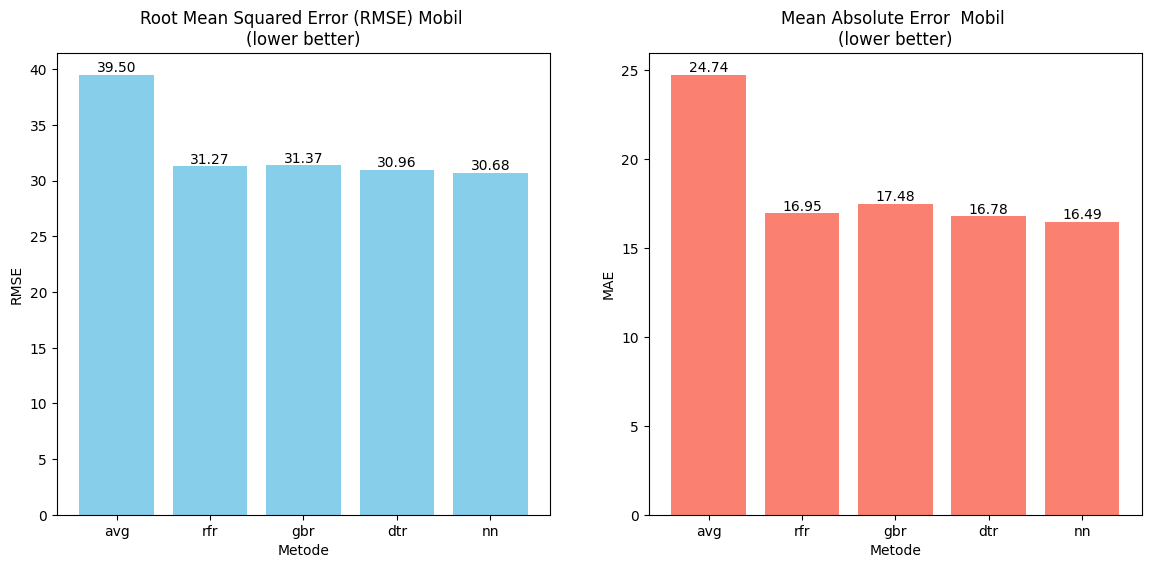

In [50]:
# Membuat figure dan dua subplot (untuk MSE dan R²)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot rMSE
bars_rmse = ax[0].bar(rmses.keys(), rmses.values(), color='skyblue')
ax[0].set_title('Root Mean Squared Error (RMSE) Mobil \n(lower better)')
ax[0].set_xlabel('Metode')
ax[0].set_ylabel('RMSE')
# Menampilkan nilai pada batang RMSE
for bar in bars_rmse:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Plot MAE
bars_mae = ax[1].bar(maes.keys(), maes.values(), color='salmon')
ax[1].set_title('Mean Absolute Error  Mobil \n(lower better)')
ax[1].set_xlabel('Metode')
ax[1].set_ylabel('MAE')

# Menampilkan nilai pada batang RMSE
for bar in bars_mae:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

In [51]:
print(mses)
print(maes)
print(rmses)
print(r2s)

{'avg': 1560.3014382074384, 'rfr': 978.1190322188756, 'gbr': 984.3390370483099, 'dtr': 958.5778143294928, 'nn': 941.3347591168811}
{'avg': 24.741460817735142, 'rfr': 16.95304543976684, 'gbr': 17.481564443658716, 'dtr': 16.776350599518832, 'nn': 16.485558870392566}
{'avg': 39.50065111118345, 'rfr': 31.274894599644547, 'gbr': 31.3741778704767, 'dtr': 30.960907840848154, 'nn': 30.68117923282743}
{'avg': 0.7651259619965884, 'rfr': 0.11948198663264531, 'gbr': 0.11388264124098613, 'dtr': 0.13707329585776595, 'nn': 0.15259576318543877}


In [52]:
# Gabungkan tabel berdasarkan kolom "Actual"
result = data_avg.merge(data_rfr[['Predicted_rfr','Residual_rfr']], left_index=True, right_index=True) \
                 .merge(data_gbr[['Predicted_gbr','Residual_gbr']], left_index=True, right_index=True) \
                 .merge(data_dtr[['Predicted_dtr','Residual_dtr']], left_index=True, right_index=True) \
                 .merge(data_nn[['Predicted_nn','Residual_nn']], left_index=True, right_index=True)
result.head()

,Actual,Predicted_avg,Residual_avg,Predicted_rfr,Residual_rfr,Predicted_gbr,Residual_gbr,Predicted_dtr,Residual_dtr,Predicted_nn,Residual_nn
0,43,66.263158,-23.263158,82.405778,-46.405778,70.720673,-34.720673,76.181818,-40.181818,72.264053,-36.264053
1,62,91.960000,-29.960000,68.004570,-18.004570,70.720673,-20.720673,68.025830,-18.025830,70.185287,-20.185287
2,156,122.736842,33.263158,84.876533,-10.876533,75.806362,-1.806362,82.052632,-8.052632,74.243599,-0.243599
3,339,295.384615,43.615385,73.843196,-0.843196,66.519702,6.480298,73.500000,-0.500000,65.686340,7.313660
4,170,180.541667,-10.541667,69.464700,11.535300,73.863629,7.136371,70.492308,10.507692,69.095375,11.904625


In [53]:
import seaborn as sns

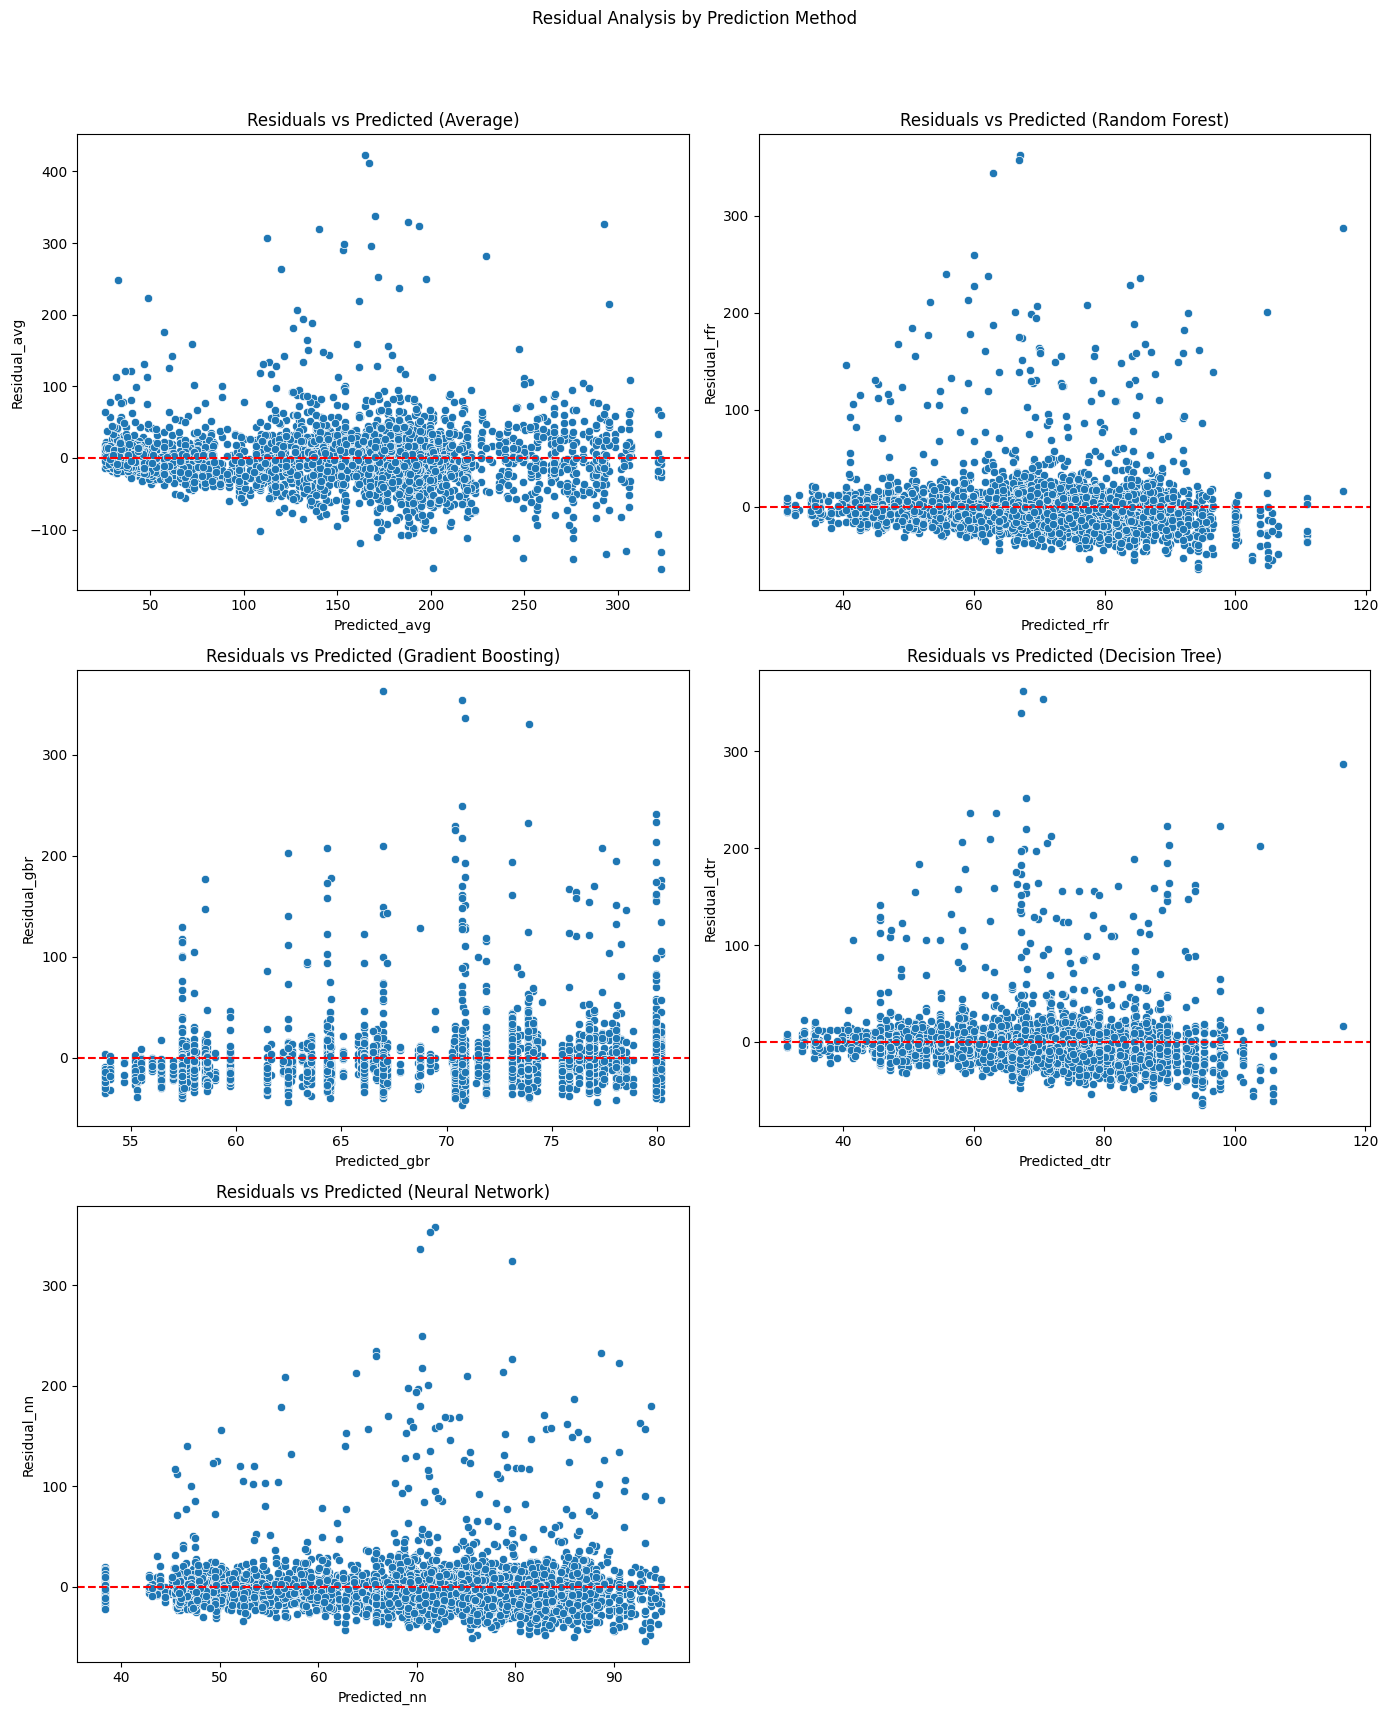

In [54]:
# Creating a DataFrame
df = result.copy()

# Set up the plot grid
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('Residual Analysis by Prediction Method')

# Scatter plot for each model's residuals
sns.scatterplot(x=df['Predicted_avg'], y=df['Residual_avg'], ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals vs Predicted (Average)')
axes[0, 0].set_xlabel('Predicted_avg')
axes[0, 0].set_ylabel('Residual_avg')

sns.scatterplot(x=df['Predicted_rfr'], y=df['Residual_rfr'], ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title('Residuals vs Predicted (Random Forest)')
axes[0, 1].set_xlabel('Predicted_rfr')
axes[0, 1].set_ylabel('Residual_rfr')

sns.scatterplot(x=df['Predicted_gbr'], y=df['Residual_gbr'], ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals vs Predicted (Gradient Boosting)')
axes[1, 0].set_xlabel('Predicted_gbr')
axes[1, 0].set_ylabel('Residual_gbr')

sns.scatterplot(x=df['Predicted_dtr'], y=df['Residual_dtr'], ax=axes[1, 1])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals vs Predicted (Decision Tree)')
axes[1, 1].set_xlabel('Predicted_dtr')
axes[1, 1].set_ylabel('Residual_dtr')

sns.scatterplot(x=df['Predicted_nn'], y=df['Residual_nn'], ax=axes[2, 0])
axes[2, 0].axhline(0, color='red', linestyle='--')
axes[2, 0].set_title('Residuals vs Predicted (Neural Network)')
axes[2, 0].set_xlabel('Predicted_nn')
axes[2, 0].set_ylabel('Residual_nn')

# Hide the last empty plot (since we have an odd number of plots)
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()